# Прогнозирование заказов в такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Импортирование библиотек и общие настройки

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')
seed = 2117

## Чтение данных

In [21]:
try:
    df = pd.read_csv('/Users/daniilkorolev/Downloads/data/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [22]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [24]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


## Предобработка и анализ данных

In [25]:
data = df.resample('1H').sum()

In [26]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [27]:
# #plt.plot(df.index, df['num_orders'], color='orange', alpha=0.5)
# plt.figure(figsize=(20, 10))
# plt.title('График сразвнения данных ДО и ПОСЛЕ ресемплинга')
# plt.xlabel('Дата')
# plt.ylabel('Количество заказов')


# sns.lineplot(x=df.index, y=df['num_orders'], alpha=0.7, label='BEFORE resample', palette='dark', color='purple')
# sns.lineplot(x=data.index, y=data['num_orders'], alpha=0.7, label='AFTER Resample', palette='winter')
# plt.legend(fontsize='20', title_fontsize='20')

In [28]:
decomposed = seasonal_decompose(data)

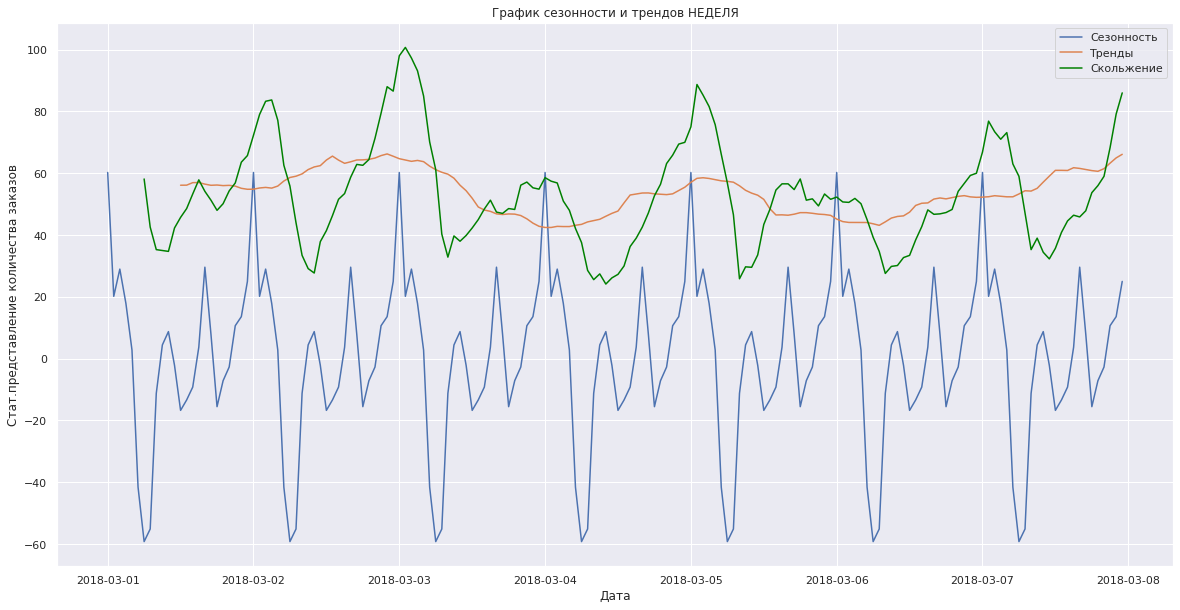

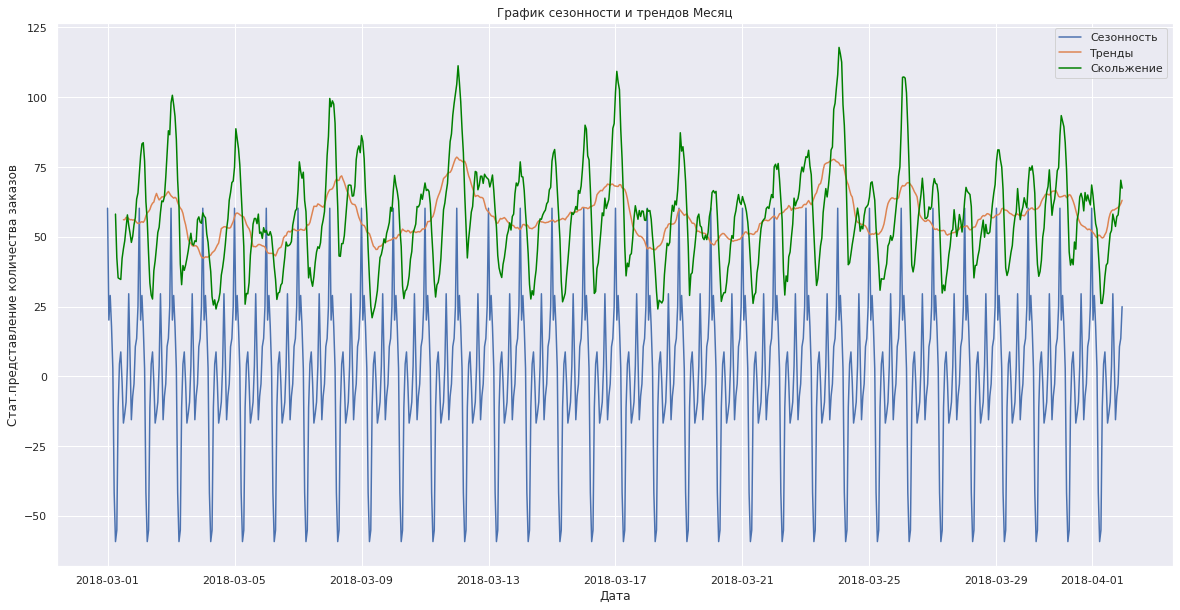

In [35]:
plt.figure(figsize=(20, 10))
plt.title('График сезонности и трендов НЕДЕЛЯ')
plt.xlabel('Дата')
plt.ylabel('Стат.представление количества заказов')

sns.lineplot(data=decomposed.seasonal['2018-03-01':'2018-03-07'], label='Сезонность')
sns.lineplot(data=decomposed.trend['2018-03-01':'2018-03-07'], label='Тренды')
sns.lineplot(data=data['num_orders']['2018-03-01':'2018-03-07'].rolling(7).mean(), color='green', label='Скольжение')
plt.show()


plt.figure(figsize=(20, 10))
plt.title('График сезонности и трендов Месяц')
plt.xlabel('Дата')

plt.ylabel('Стат.представление количества заказов')
sns.lineplot(data=decomposed.seasonal['2018-03-01':'2018-04-01'], label='Сезонность')
sns.lineplot(data=decomposed.trend['2018-03-01':'2018-04-01'], label='Тренды')
sns.lineplot(data=data['num_orders']['2018-03-01':'2018-04-01'].rolling(7).mean(), color='green', label='Скольжение')
plt.show()
sns.lineplot(x=df.index, y=df['num_orders'], alpha=0.7, label='BEFORE resample', palette='dark', color='purple')
ddzsns.lineplot(x=data.index, y=data['num_orders'], alpha=0.7, label='AFTER Resample', palette='winter')
plt.legend(fontsize='20', title_fontsize='20')

<AxesSubplot:title={'center':'Остатки'}, xlabel='datetime', ylabel='resid'>

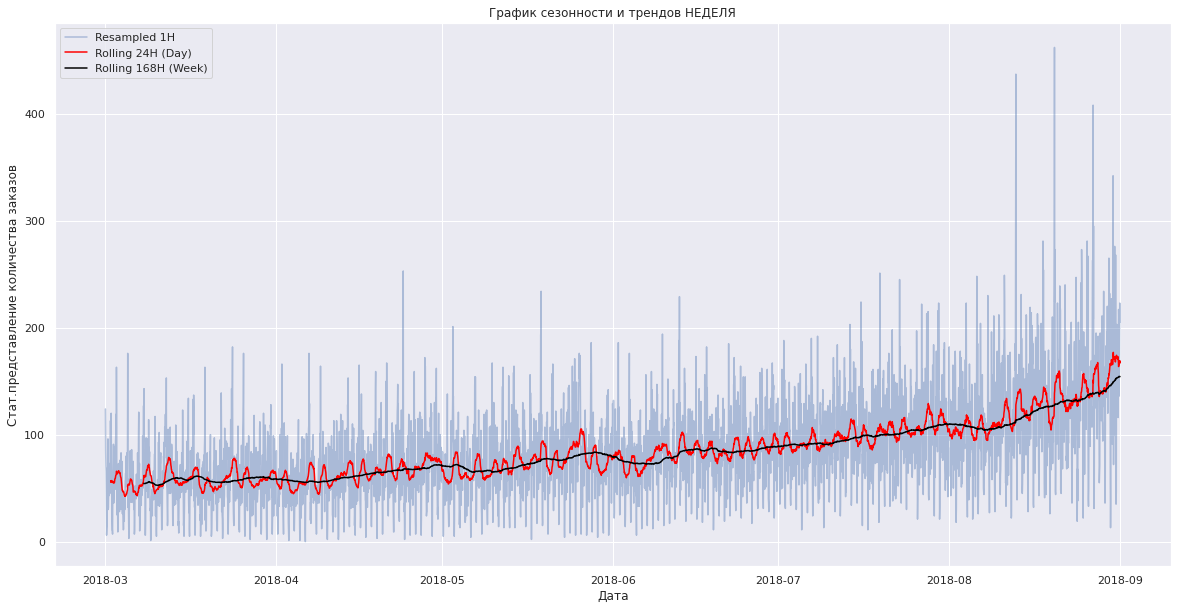

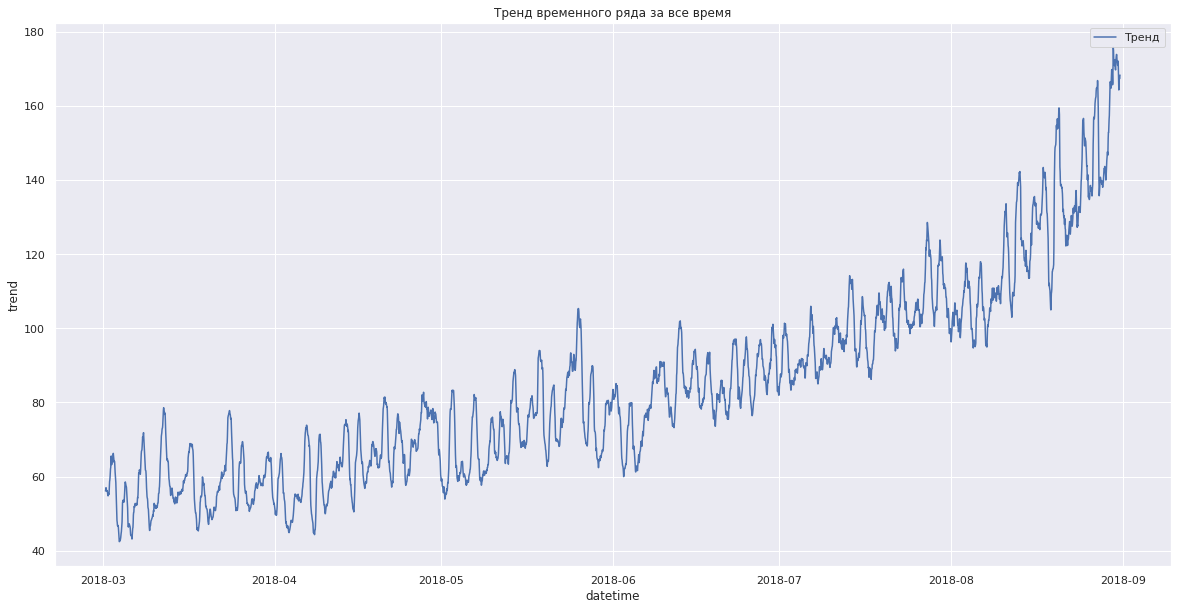

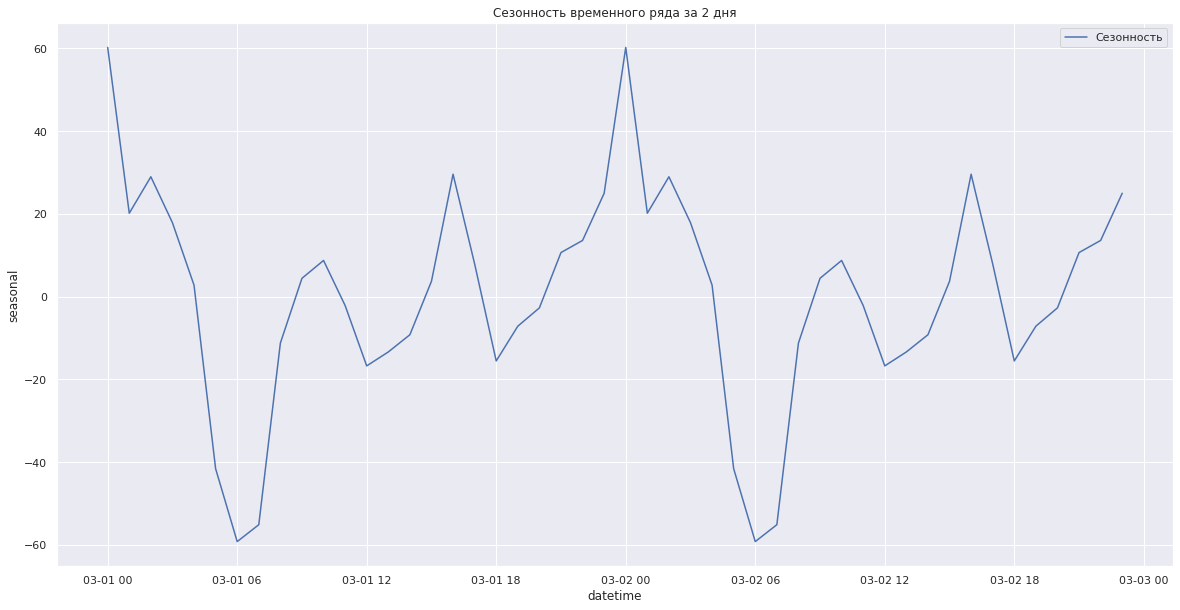

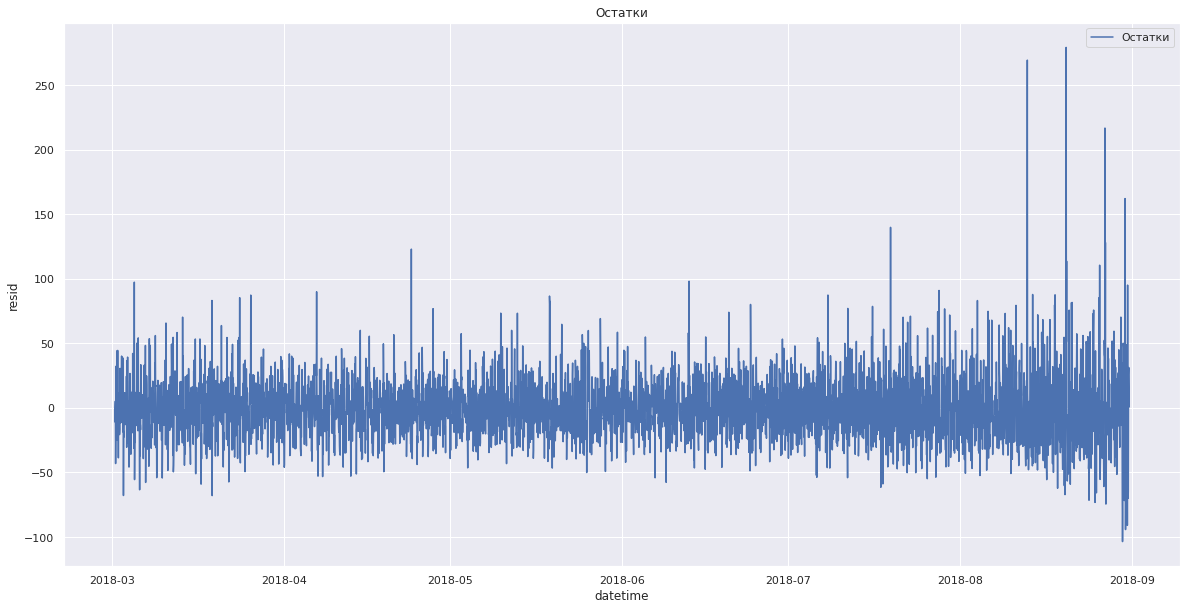

In [67]:
plt.figure(figsize=(20, 10))
plt.title('График сезонности и трендов НЕДЕЛЯ')
plt.xlabel('Дата')
plt.ylabel('Стат.представление количества заказов')

sns.lineplot(data=data['num_orders'], label='Resampled 1H', alpha=0.4)
sns.lineplot(data=data['num_orders'].rolling(24).mean(), label='Rolling 24H (Day)', color='red')
sns.lineplot(data=data['num_orders'].rolling(168).mean(), label='Rolling 168H (Week)', color='black')


plt.figure(figsize=(20, 10))
plt.title('Тренд временного ряда за все время')
sns.lineplot(data=decomposed.trend, label='Тренд')

plt.figure(figsize=(20, 10))
plt.title('Сезонность временного ряда за 2 дня')
sns.lineplot(data=decomposed.seasonal['2018-03-01':'2018-03-02'], label='Сезонность')

plt.figure(figsize=(20, 10))
plt.title('Остатки')
sns.lineplot(data=decomposed.resid, label=<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
Исполнено ниже

</div>'Остатки')


В графиках замечена сезонность по дням и по неделям

In [11]:
def data_weawer(data, shift_number, rolling_size):
    
    # блок дат
    #data['year'] = data.index.year
    #data['month'] = data.index.month
    #data['weeknumber'] = data.index.isocalendar().week
    data['day_of_week'] = data.index.dayofweek + 1
    data['hour'] = data.index.hour
    
    # блок генератора отставания
    for i in range(1, shift_number + 1):
        
        data['lag_{}'.format(i)] = data['num_orders'].shift(i)
        
    # блок скользящего среднего
    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_size).mean()
    

data_weawer(data, 7, 7)

data

,num_orders,day_of_week,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,4,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,4,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,4,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,5,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.428571
2018-08-31 20:00:00,154,5,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,167.428571
2018-08-31 21:00:00,159,5,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,165.714286


Успешно создана функция для создания дополнительных признаков, признаки создаются корректно

In [12]:
data = data.dropna()
data.duplicated().sum()

0

По этому графику видно, что в нашем случае типична ситуация с 40-135 заказов в час, и причем шансы получить менее 40 заказов выше, чем получить более 200

Если честно очень 

После декомпозирования данных была выявлена сезонность по дням и по неделям, на основе этих сведений итоговые данные были дополнены созданными признаками дня недели, часа, сдвига и скользящего среднего

## Моделирование

In [14]:
X = data.drop(['num_orders'], axis=1)
y = data['num_orders']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False, random_state=seed)

results = {}

In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3968, 10), (3968,), (441, 10), (441,))

### LinearRegression

In [16]:
#lin_model = LinearRegression()

scaler = StandardScaler()

X_train_s = scaler.fit_transform(X_train)

tscv = TimeSeriesSplit(n_splits=5)

params = {}

grid_search = GridSearchCV(LinearRegression(), params, cv=tscv, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

#lin_model.fit(X_train_s, y_train)

#lin_preds = lin_model.predict(X_train_s)

#lin_results = (mean_squared_error(y_train, lin_preds)**0.5)

#print(lin_results)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
rmse_lr = abs(grid_search.best_score_)**0.5
print(rmse_lr)

33.11238650730822


### RandomForest

In [17]:
%%time

params = {
    'n_estimators': [1000, 1500],
    'max_features': ['auto'],
    'max_depth': [ 5, 7],
    #'min_samples_split': [5, 10],
    #'min_samples_leaf': [2, 4],
    #'criterion': ['squared_error'],
    'n_jobs': [-1],
    'verbose': [0],
    'random_state': [seed]
}

tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(RandomForestRegressor(), params, cv=tscv, scoring='neg_root_mean_squared_error')

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
rmse_rf = -(grid_search.best_score_)

CPU times: user 2min 26s, sys: 482 ms, total: 2min 26s
Wall time: 2min 26s


### CatBoost

In [18]:
params = {
    'iterations':[200, 300],
    'learning_rate':[0.1, 0.2],
    'depth':[4, 7]
}
tscv = TimeSeriesSplit(n_splits=5)

cb_model = CatBoostRegressor(verbose=0, random_seed=seed)
grid_search = GridSearchCV(estimator=cb_model, param_grid=params, cv=tscv, scoring='neg_root_mean_squared_error')

grid_search.fit(X_train, y_train)

# Лучшая модель и параметры
best_model_cb = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Лучшие параметры:", best_params)
print("Лучший результат (MSE):", best_score)
rmse_cb = -(best_score)
print('Результат RMSE для CatBoost', rmse_cb)

Лучшие параметры: {'depth': 7, 'iterations': 200, 'learning_rate': 0.1}
Лучший результат (MSE): -26.216041503637275
Результат RMSE для CatBoost 26.216041503637275


### Таблица результатов

In [19]:
results = {
    'Модель':['LinearRegression', 'RandomForest', 'CatBoost'],
    'Результат на тренировочной выборке':[rmse_lr, rmse_rf, rmse_cb]
}

df = pd.DataFrame(results)
df.set_index('Модель', inplace=True)
df

,Результат на тренировочной выборке
Модель,
LinearRegression,33.112387
RandomForest,27.245978
CatBoost,26.216042


Лучший результат показала самая простая линейная регрессия

In [20]:
lin_t_preds = best_model_cb.predict(X_test)
print('Результат лучшей модели на тестовой выборке', mean_squared_error(y_test, lin_t_preds)**0.5)

Результат лучшей модели на тестовой выборке 45.364849472954745


## Вывод

Мною был выполнен проект по прогнозированию временных рядов, я преобразовал данные и создал синтетические признаки, провел предобработку данных и рассмотрел 3 разных модели.

Лучший результат показала линейная регрессия именно ее я бы и посоветовал использовать заказчику.